#### Install (Google Colab)

In [28]:
%%capture
import os
import torch
os.environ['TORCH'] = "2.4.0+" + torch.__version__.split("+")[-1]
!pip install yfiles_jupyter_graphs
!pip install gdown
!pip install toolz
!pip install oxrdflib
!pip install rdflib
!pip install torch-geometric

In [ ]:
%%capture
# Be patient this can take up to 40 minutes ...
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/torch-${TORCH}.html

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

#### Import

In [1]:
import torch
import matplotlib as mpl
import pickle
import numpy as np
import networkx as nx
from yfiles_jupyter_graphs import GraphWidget
from functools import reduce
from typing import Dict, List, Union, Tuple
from pprint import pprint
import rdflib
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from hashlib import md5
import re
from shapely import wkt
import plotly.graph_objs as go
import pandas as pd
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero, RGCNConv
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import tqdm
import gdown
import os
import io
from openai import OpenAI
import getpass
import toolz
from itertools import combinations
from copy import copy
if not os.path.exists("data"):
    os.mkdir("data")

#### Utils

In [5]:
def download_file(
    id: str,
    output: str 
) -> None:

    if not os.path.exists(output):
        gdown.download(id=id, output=output)
    return None


def download_gnn_dataset() -> str:

    download_file("1kAbMggXOY_sdwR29lK7GWUmSxaUBCtcX", "data/gnn_train.pkl")   
    download_file("1l33Q39DH6vtcVbtk5X0swpRu6hpcnAdE", "data/gnn_val.pkl") 
    download_file("1QyQNCs6VqGC-vXlsvntuRXc5a5OaaVjX", "data/gnn_test.pkl")
    return "ok"


def get_subgraph(
    g:nx.Graph,
    root:str,
    depth:int
) -> nx.Graph:

    sub_nodes = [root]
    current_nodes = [root]
    for _ in range(depth):
        temp = []
        for n in current_nodes:
            neighbors = [*g.neighbors(n)]
            sub_nodes += neighbors
            temp += neighbors
        current_nodes = [*set(temp)]
    return g.subgraph(sub_nodes)


def plot_graph(
    graph:nx.Graph,
    **kwargs
) -> GraphWidget:

    widget_layout = kwargs.get("widget_layout", None)
    features = kwargs.get("features", None) 
    sidebar = kwargs.get("sidebar", False) 
    overview_enabled = kwargs.get("overview_enabled", False)
    node_label = kwargs.get("node_label", None) 
    edge_label = kwargs.get("edge_label", None)
    layout = kwargs.get("layout", "organic")
    widget = GraphWidget(widget_layout=widget_layout,overview_enabled=overview_enabled)
    if features:
        feature_dict = features if isinstance(features,dict) else nx.get_node_attributes(graph, features)
        colored_graph = graph_nodes_colors(graph,feature_dict)
        widget.import_graph(colored_graph)
        widget.set_node_color_mapping("color")
    else:
        colored_graph = graph.copy()
        widget.import_graph(colored_graph)
    if node_label:
        widget.node_label_mapping = node_label
    if edge_label:
        widget.edge_label_mapping = edge_label
    widget.set_sidebar(sidebar)
    widget.set_graph_layout(layout)
    return widget


def graph_nodes_colors(
    g:nx.Graph,
    features:Dict,
    colors:Union[List,Tuple]=("#440154FF","#FDE725FF"),
    ref:str="color"
) -> nx.Graph:

    graph = g.copy()
    values = [*features.values()]
    if isinstance(values[0], (str)):
        vmap = dict(map(reversed,enumerate(set(values))))
        features = dict(map(lambda x: [x[0],vmap[x[1]]], features.items()))
        values = [*features.values()]
    values_arr = np.array(values)    
    scaled_features = dict(zip(features.keys(),(1000*((values_arr - values_arr.min())/values_arr.max())).astype(int).tolist()))    
    colors = color_generator(colors[0],colors[1],max(scaled_features.values()))
    for key,val in scaled_features.items():
        graph.nodes[key][ref] = colors[val]
    return graph


def color_generator(
    c1:str,
    c2:str,
    n:int
) -> Dict:

    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    colors = dict(enumerate(map(lambda x: mpl.colors.to_hex((1-(x/n))*c1 + (x/n)*c2) ,range(n+1))))
    return colors


def rdf_to_graph(
    rdf:rdflib.Graph,
    **kwargs
) -> nx.Graph:
  
    base = kwargs.get("base", "ex")
    resource = kwargs.get("resource", "resource")
    etype = kwargs.get("etype", "etype")
    ns_rev = dict(rdf.namespaces())
    ns = dict(map(lambda x: [str(x[1]),x[0]], ns_rev.items()))
    pattern = '|'.join(sorted(re.escape(k) for k in ns))
    strip_ns = lambda x: re.sub(pattern, lambda m: ns.get(m.group(0))+":", x)
    node_type = lambda n: resource if ns_rev[base] in str(n) else "literal" if type(n)==rdflib.Literal else "concept"
    triples = [*rdf.triples([None,None,None])]
    nodes = {}
    edges = {}
    for sub,pre,obj in triples:
        s,p,o = [*map(strip_ns,map(str,[sub,pre,obj]))]
        nodes[s] = {"iri":s, "name":s, etype: node_type(sub)  }
        if type(obj) == rdflib.Literal:
            tmp = md5((s+p+o).encode()).hexdigest()
            nodes[tmp] = {"name":o, etype: node_type(obj) }
            edges[(s,tmp)] = {"type":p}
        else:
            nodes[o] = {"iri":o,"name":o, etype: node_type(obj)}
            edges[(s,o)] = {"type":p}
    g = nx.DiGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    nx.set_node_attributes(g,nodes)
    nx.set_edge_attributes(g,edges)
    return g 


def rdf_to_property_graph(
    rdf:rdflib.Graph,
    **kwargs    
) -> nx.DiGraph:

    attr = kwargs.get("attr", "name") # field that contains the node property value 
    etype = kwargs.get("etype", "etype") # field for the entity type (resource, literal, concept)
    rtype = kwargs.get("rtype", "type") # field for the relation type
    resource = kwargs.get("resource", "resource") # resource etype name
    g = rdf_to_graph(rdf, **kwargs)
    get_edge = lambda s,t: g.edges[(s,t)]
    is_resource = lambda n: g.nodes[n][etype] == resource
    get_attr = lambda s,t: {(s, get_edge(s,t)[rtype]): g.nodes[t][attr]}
    get_properties = lambda s: [*map(lambda t: get_attr(s,t), filter(lambda x: not is_resource(x), g.neighbors(s)))]
    get_edges = lambda s: [*map(lambda t: {(s,t): get_edge(s,t)}, filter(is_resource, g.neighbors(s)))]
    resources = [*filter(is_resource, g.nodes())]
    prop_dicts = [*map(get_properties, resources)]
    edge_dicts = [*map(get_edges, resources)]
    props = toolz.merge_with(list, [item for sublist in prop_dicts for item in sublist])
    edges = toolz.merge([item for sublist in edge_dicts for item in sublist])
    properties = toolz.valmap(lambda x: x if len(x)>1 else x[0],  props)
    nodes = toolz.merge_with( toolz.merge, map(lambda x: {x[0][0] : {x[0][1]:x[1]}}, properties.items()))
    ng = nx.DiGraph()
    ng.add_nodes_from(nodes)
    ng.add_edges_from(edges)
    nx.set_node_attributes(ng,nodes)
    nx.set_edge_attributes(ng,edges)
    return ng
 

# The aspect ratio needs to fixed
def plot_floorplan(
    g:nx.Graph, 
    attr:str, 
    size:int=1000,
    names:Union[Dict,None]=None,
    **kwargs 
) -> go.Figure:
    
    color = kwargs.get("color") if "color" in kwargs else "rgb(100,100,200)"
    layout = dict(
        xaxis = {"showgrid":False,"zeroline":False,"showticklabels":False},
        yaxis = {"showgrid":False,"zeroline":False,"showticklabels":False},
        height = size,
        width = size,
        margin = dict(b=0,l=0,pad=0,r=0,t=30),
        paper_bgcolor ='rgba(0,0,0,0)',
        plot_bgcolor  ='rgba(0,0,0,0)'
    )
    polygons_dict = dict(nx.get_node_attributes(g, attr))
    polygons = [*polygons_dict.values()]
    if not names:
        names = dict(map(lambda k: [k,None], polygons_dict.keys()))
    data = []
    for key,val in polygons_dict.items():
        poly = wkt.loads(val)
        xx,yy = [*map(list,poly.exterior.xy)]
        data.append(go.Scatter(x=xx, y=yy, name=names[key], fill="toself",showlegend=False, line={"color":color}))
    fig = go.Figure(data=data,layout=layout)
    return fig


def plot_bar(
    data:Union[List[Dict],Dict],
    height:int=600, 
    **kwargs
) -> go.Figure:

    width = None if not kwargs.get('width') else kwargs.get('width')
    title = None if not kwargs.get('title') else kwargs.get('title')
    xaxis_title = None if not kwargs.get('xaxis_title') else kwargs.get('xaxis_title')
    yaxis_title = None if not kwargs.get('yaxis_title') else kwargs.get('yaxis_title')
    layout = dict(
        xaxis = {"showgrid":False, "gridcolor":"rgb(50,50,50)", "tickfont":{"size":10,"color":"grey"} },
        yaxis = {"showgrid":False, "gridcolor":"rgb(50,50,50)", "tickfont":{"size":10,"color":"grey"}},
        xaxis_title = xaxis_title,
        yaxis_title = yaxis_title,
        font = {"color":"grey"},
        title = title,
        height = height,
        width = width,
        margin = dict(b=0,l=0,pad=0,r=0,t=30),
        paper_bgcolor ='rgba(0,0,0,0)',
        plot_bgcolor  ='rgba(0,0,0,0)'
    )
    data = [data] if isinstance(data,dict) else data
    fig_data = []
    for i,d in enumerate(data):
        fig_data.append(
            go.Bar(
                x=[*d.keys()],
                y=[*d.values()]
            )
        )
    figure = go.Figure(data=fig_data,layout=layout)
    return figure


def polygon_room_names(
    g:nx.Graph
) -> Dict:

    geom_edges = filter(lambda e: g.edges[e]["type"]=="rec:geometry", g.edges())
    return dict(map(lambda x: [x[1], ", ".join(g.nodes[x[0]]["rdfs:label"]) ],geom_edges))


## Graphs

- Graph theory is a topic in discrete Mathematics that deals with collections of objects and their relations.

- Objects are represented as vertices (or nodes) and relations as edges.

- It is very common to represent Graphs in a diagrammatic form.

> *https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)*



$G = (V,E)$ with $V=(V_1,V_2,...,V_n)$ and $E = ((V_i,V_j); i\geq 1, j\leq n )$

In [3]:
nodes = [ 1, 2, 3, 4, 5, 6, 7 ]

edges = [(1,2), 
         (1,3), 
         (1,7), 
         (2,3), 
         (3,4),
         (3,7), 
         (4,6), 
         (4,5), 
         (5,6), 
         (6,7)
        ]
        
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
plot_graph(g)

GraphWidget(layout=Layout(height='500px', width='100%'))

In [4]:
print("Adjacency Matrix of `g`:\n")
adjacency_matrix = nx.to_numpy_array(g)
print(adjacency_matrix)
print(f"\nShape: {adjacency_matrix.shape}")
print(f"\nSum: {int(adjacency_matrix.sum())}")
print(f"\nGraph edges: {len(g.edges())}")

Adjacency Matrix of `g`:

[[0. 1. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 0. 1. 0.]]

Shape: (7, 7)

Sum: 20

Graph edges: 10


We can distinguish between different types of graphs, based on the relations that are allowed between the nodes.<br> Some common ones are:

- Undirected Graphs

- Directed Graphs

- Undirected Multigraphs 

- Directed Multigraphs

- Bipartite Graphs

- ...

**Directed Multigraph**

In a nutshell:
- Directed: the order of the edge matters: $(x,y)\not=(y,x)$

- Multigraph: multiple edges between two nodes are allowed. The edges can either have their own identity or not. Self-loops can be allowed or not.

In general, for a directed multigraph that permits self-loops ([quiver](https://en.wikipedia.org/wiki/Quiver_(mathematics))), $G$ is an ordered 4-tuple $G = (V,E,s,t)$ , where: <br>
$V$ : set of nodes <br>
$E$ : set of edges <br>
$s: E \rightarrow V$ : assiging source node to each edge <br>
$t: E \rightarrow V$ : assiging target node to each edge <br>

In [6]:
multidigraph = nx.MultiDiGraph()
multidigraph.add_nodes_from(nodes)
multidigraph.add_edges_from(edges + [(1,1),(5,5),(7,6),(6,7),(3,4)])
plot_graph(multidigraph)

GraphWidget(layout=Layout(height='500px', width='100%'))

In [7]:
print("Adjacency Matrix of `multi_directed_g`:\n")
multi_adjacency_matrix = nx.to_numpy_array(multidigraph)
print(multi_adjacency_matrix)
print(f"\nShape: {multi_adjacency_matrix.shape}")
print(f"\nSum: {int(multi_adjacency_matrix.sum())}")
print(f"\nGraph edges: {len(multidigraph.edges())}")

Adjacency Matrix of `multi_directed_g`:

[[1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0. 1. 0.]]

Shape: (7, 7)

Sum: 15

Graph edges: 15


## Homogeneous And Heterogeneous Graphs

We can define a graph $G = (V,E,R,T)$ where <br>
- $V$ are the graph's nodes, <br>
- edges are triples of the form $(v_i,r,v_j)∈E$ where $r$ represents a relation type, <br>
- $T$ and $R$ are node and edge types, <br>
- a $v_i∈V$ node's type can be derived with $T(v_i)$.

When $G$ consists of only one type of nodes and one type of edges, it can be considered **homogeneous**.

In [8]:
g1 = g.to_directed().copy() 

node_types = dict(map(lambda n: [n,{"type":"A"}], g1.nodes()))
nx.set_node_attributes(g1,node_types)

print("Node types:")
pprint(node_types)

edge_types = dict(map(lambda e: [e,{"type":"f"}], g1.edges()))
nx.set_edge_attributes(g1,edge_types)

print("\nEdge types:")
pprint(edge_types)

Node types:
{1: {'type': 'A'},
 2: {'type': 'A'},
 3: {'type': 'A'},
 4: {'type': 'A'},
 5: {'type': 'A'},
 6: {'type': 'A'},
 7: {'type': 'A'}}

Edge types:
{(1, 2): {'type': 'f'},
 (1, 3): {'type': 'f'},
 (1, 7): {'type': 'f'},
 (2, 1): {'type': 'f'},
 (2, 3): {'type': 'f'},
 (3, 1): {'type': 'f'},
 (3, 2): {'type': 'f'},
 (3, 4): {'type': 'f'},
 (3, 7): {'type': 'f'},
 (4, 3): {'type': 'f'},
 (4, 5): {'type': 'f'},
 (4, 6): {'type': 'f'},
 (5, 4): {'type': 'f'},
 (5, 6): {'type': 'f'},
 (6, 4): {'type': 'f'},
 (6, 5): {'type': 'f'},
 (6, 7): {'type': 'f'},
 (7, 1): {'type': 'f'},
 (7, 3): {'type': 'f'},
 (7, 6): {'type': 'f'}}


In [9]:
plot_graph(g1, node_label="type", edge_label="type")

GraphWidget(layout=Layout(height='500px', width='100%'))

When a graph consists of multiple types of nodes or edges it is considered as **heterogeneous**.

In [10]:
g2 = multidigraph.copy()

node_types = dict(map(lambda n: [n,{"type":"A"}] if n%2==0 else [n,{"type":"B"}], g2.nodes()))
nx.set_node_attributes(g2,node_types)

edge_types = dict(map(lambda e: [e,{"type":"f"}] if sum(e)%2==0 else [e,{"type":"g"}] , g2.edges(keys=True)))
nx.set_edge_attributes(g2,edge_types)

plot_graph(g2, node_label="type", edge_label="type")

GraphWidget(layout=Layout(height='500px', width='100%'))

## Knowledge Graphs

A Knowledge Graph (KG) is basically a graph representation of a Knowledge Base.
- Most commonly KGs belong to the family of **heterogeneous directed multigraphs** (with self-loops).

- KGs include representations of factual relations between entities, as well as conceptual representations that are linked to them.


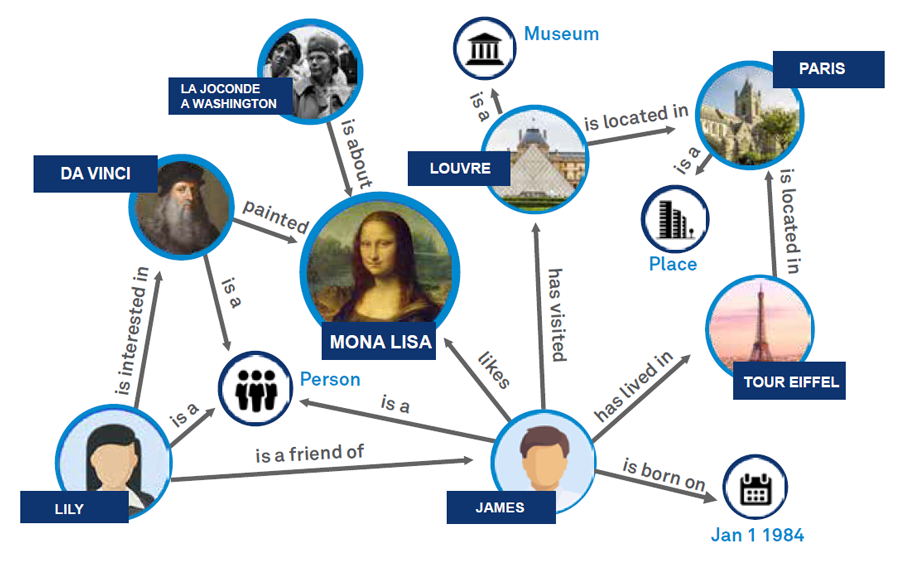

[image source](https://www.wipro.com/content/dam/nexus/en/service-lines/business-process/infographics/knowledge-graphs-transform-semantic-analytics-towards-a-semantic-web-fig1-desktop.png)



### Basic Concepts

Two widespread use-cases of KGs are:

- Organising knowledge over the Internet.

- Integrating data in enterprises or organisations.

---

KGs are usually represented as a set of triples of the form: <br>
> *\<subject> \<predicate> \<object>* <br>

where objects can be entities:
> eg. *Mary knows* **John**<br>


or literal values: <br>
> eg. *Mary age* **24**

---

KG entities must be uniquely identified. It is common to use network URIs. <br>
For example, following Turtle serialisation we have: <br>
```
@base <https://mydomainname.org/resources/> .
@prefix ont: <https://somepublicontology.org/concepts#> .

base:Mary ont:knows base:John .
```


In [13]:
## DUMMY KG
g = Graph()

base = Namespace("https://mydomainname.org/resources/")
ont = Namespace("https://somepublicontology.org/concepts#")

g.bind("base", base)
g.bind("ont", ont)

#! For readability we use simple names for the `base`` URIs in this dummy example
#! but in practice we would use UUIDs 

g.add((URIRef("Mary", base), ont["knows"], URIRef("John", base)))
g.add((URIRef("John", base), ont["knows"], URIRef("Mary", base)))
g.add((URIRef("Mary", base), ont["age"], Literal(25)))
g.add((URIRef("John", base), ont["age"], Literal(25)))
g.add((URIRef("Mary", base), ont["type"], ont["Human"]))
g.add((URIRef("John", base), ont["type"], ont["Human"]))
g.add((ont["Human"], ont["subclass"], ont["BiologicalOrganism"]))

<Graph identifier=Na7833d9af49b42c49b69cd849ee95050 (<class 'rdflib.graph.Graph'>)>

In [12]:
plot_graph(rdf_to_graph(g, base="base"), edge_label="type", node_label="name", features="etype")

GraphWidget(layout=Layout(height='500px', width='100%'))

### Challenges

Some practical concerns that arise when building a KG.

- One needs to develop a good understanding of what exactly needs to be represented in the KG.

- What are the resources?

- What *common knowledge* should be included?

- Is there a need to create some new ontology or add an extension to an existing one?

- How to populate the KG in a scaleable way.

- How to deal with KG incompleteness.

- ...

## Building the `Swiss Dwellings` Graph

Dataset of ~45000 apartments in Switzerland.

Swiss dwellings dataset:

```
Matthias Standfest, Michael Franzen, Yvonne Schröder, Luis Gonzalez Medina, Yarilo Villanueva Hernandez, Jan Hendrik Buck, Yen-Ling Tan, Milena Niedzwiecka, & Rachele Colmegna. (2022).
Swiss Dwellings: A large dataset of apartment models including aggregated geolocation-based simulation results covering viewshed, 
natural light, traffic noise, centrality and geometric analysis (3.0.0) [Data set]. 
Zenodo https://doi.org/10.5281/zenodo.7788422. 
```
[link](https://doi.org/10.5281/zenodo.7788422)

In [14]:
%%capture
download_file("1KXVzC7GnrRxyAy_hdZS3TdIRn9GHTDew", "data/geometries_v3.csv")

In [80]:
df = pd.read_csv("data/geometries_v3.csv")
print(f"Dataframe shape : {df.shape}\n")
df.head()

Dataframe shape : (3255905, 13)



,apartment_id,site_id,building_id,plan_id,floor_id,unit_id,area_id,unit_usage,entity_type,entity_subtype,geometry,elevation,height
0,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619311.0,RESIDENTIAL,area,BATHROOM,POLYGON ((-2.7337844078265210 4.07980744083215...,0.0,2.6
1,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619303.0,RESIDENTIAL,area,LIVING_ROOM,POLYGON ((5.8278988701887320 7.816876723402971...,0.0,2.6
2,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619322.0,RESIDENTIAL,area,ROOM,POLYGON ((6.7557107205191187 2.413369594812586...,0.0,2.6
3,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619310.0,RESIDENTIAL,area,KITCHEN,POLYGON ((3.5821200013910017 5.140461688341117...,0.0,2.6
4,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619312.0,RESIDENTIAL,area,ROOM,POLYGON ((3.0141380455489282 4.182056855151666...,0.0,2.6


In [81]:
df_residential = df[df["unit_usage"] == "RESIDENTIAL"]

df_residential_areas = df_residential[df_residential["entity_type"] == "area"]

df_apt = df_residential_areas[df_residential_areas["apartment_id"] == "3c3b1d6ca8b4b9092480b8c75f9eaa81"]

df_apt

,apartment_id,site_id,building_id,plan_id,floor_id,unit_id,area_id,unit_usage,entity_type,entity_subtype,geometry,elevation,height
0,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619311.0,RESIDENTIAL,area,BATHROOM,POLYGON ((-2.7337844078265210 4.07980744083215...,0.0,2.6
1,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619303.0,RESIDENTIAL,area,LIVING_ROOM,POLYGON ((5.8278988701887320 7.816876723402971...,0.0,2.6
2,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619322.0,RESIDENTIAL,area,ROOM,POLYGON ((6.7557107205191187 2.413369594812586...,0.0,2.6
3,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619310.0,RESIDENTIAL,area,KITCHEN,POLYGON ((3.5821200013910017 5.140461688341117...,0.0,2.6
4,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619312.0,RESIDENTIAL,area,ROOM,POLYGON ((3.0141380455489282 4.182056855151666...,0.0,2.6
5,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619314.0,RESIDENTIAL,area,BALCONY,POLYGON ((6.6332818443542809 1.893154628642479...,0.0,2.6
6,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619315.0,RESIDENTIAL,area,CORRIDOR,POLYGON ((-0.8407103586364295 2.49132970436546...,0.0,2.6


In [23]:
print("Example of extracting apartment-to-room connections:")

[*map(lambda x: [x[0], "has_room" ,int(x[1])], df_apt[["apartment_id","area_id"]].values)]

Example of extracting apartment-to-room connections:


[['3c3b1d6ca8b4b9092480b8c75f9eaa81', 'has_room', 619311],
 ['3c3b1d6ca8b4b9092480b8c75f9eaa81', 'has_room', 619303],
 ['3c3b1d6ca8b4b9092480b8c75f9eaa81', 'has_room', 619322],
 ['3c3b1d6ca8b4b9092480b8c75f9eaa81', 'has_room', 619310],
 ['3c3b1d6ca8b4b9092480b8c75f9eaa81', 'has_room', 619312],
 ['3c3b1d6ca8b4b9092480b8c75f9eaa81', 'has_room', 619314],
 ['3c3b1d6ca8b4b9092480b8c75f9eaa81', 'has_room', 619315]]

**Sketching out a schema**

Aligning concepts to known ontologies.
- [Real Estate Core](https://www.realestatecore.io)

- [Building Ontology Topology](https://w3c-lbd-cg.github.io/bot/)

Real Estate Core

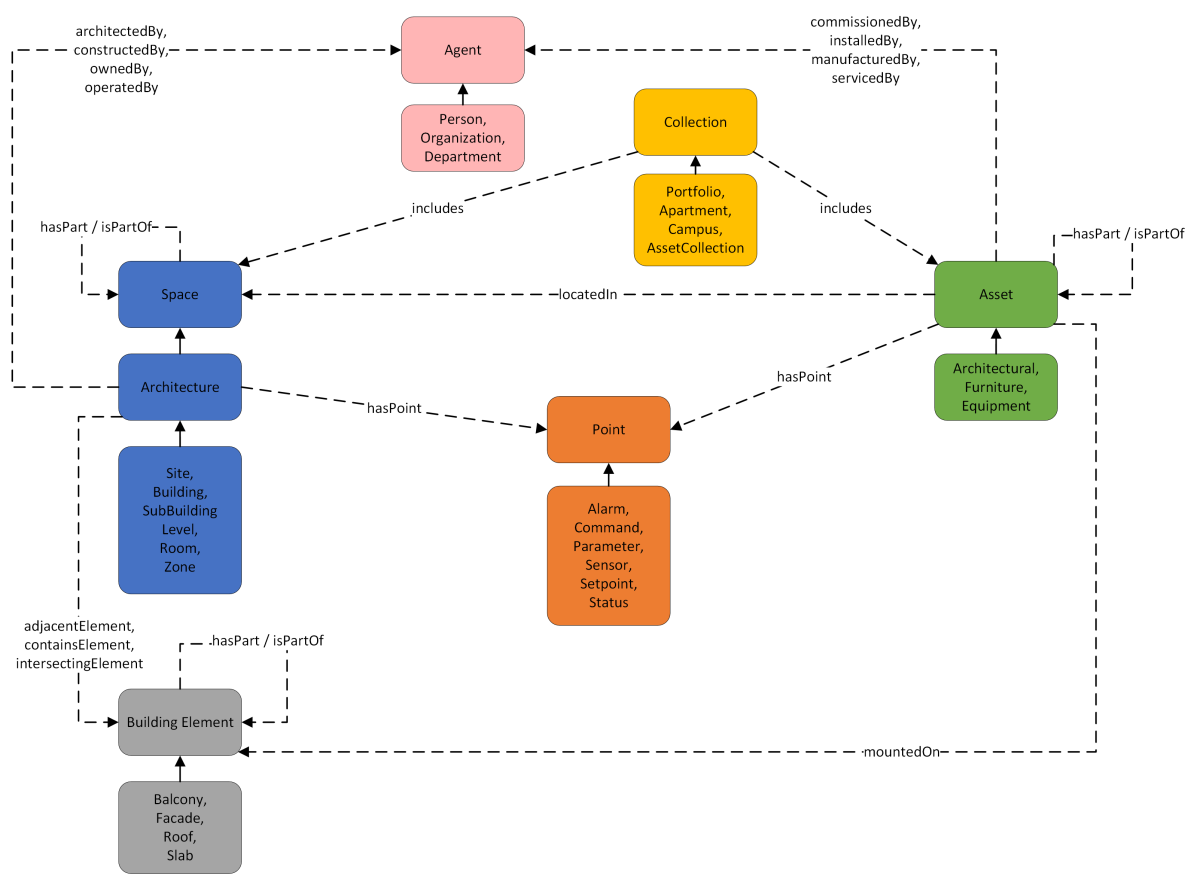

In [24]:
schema = [
    ["rec:Site", "rec:hasPart", "rec:Building"],
    ["rec:Building", "rec:hasPart", "rec:Level"],
    ["rec:Level", "rec:hasPart", "rec:Zone"],
    ["rec:Zone", "rec:hasPart", "rec:Zone"],
    ["rec:Zone", "rec:hasPart", "rec:Room"],
    ["rec:Room", "bot:adjacentZone", "rec:Room"],
    ["rec:Room", "rec:geometry", "rec:Polygon"]
]

schema_edges = dict(map(lambda x: [(x[0],x[2]),{"type":x[1]}], schema))
schema_nodes = [*set(reduce(lambda a,b:a+b, map(lambda x: [x[0],x[2]] ,schema)))]
schema_g = nx.DiGraph()
schema_g.add_nodes_from(schema_nodes)
schema_g.add_edges_from(schema_edges)
nx.set_edge_attributes(schema_g, schema_edges)
plot_graph(schema_g, edge_label="type", layout="tree")

GraphWidget(layout=Layout(height='500px', width='100%'))

- We filter the dataframe by keeping only the residential buildings.

- Most of the relationships we would like to represent are explicitly provided in the dataframe. <br> The only one that we have to infer is the space adjacency one:<br> `rec:Room <-> bot:adjacentZone <-> rec:Room`<br>

- To extract those relationships we use the polygons provided for each room and check geometrically whether the areas are 'touching' each other or whether they intersect with a common interface (a door). <br>

- We express all the relations (explicit and inferred) as RDF and save it as a Turtle file.

*The code is not provided here, in order to constrain the verbosity of the notebook, but can easily implemented using the [shapely](https://pypi.org/project/shapely/) library.*

**Load pre-processed rdf file**

In [38]:
%%capture
# Load rdf without geometry (polygon) nodes to reduce RAM usage.
# For the whole rdf use: 1UbDMQxjYjk4lOiF-2fTerpWQBp7NdXVb
download_file("1aX0Y2l387OKwOHZPUNqGcnwqezL4nk5p", "data/rdf_graph_no_geom.ttl")

In [39]:
rdf = Graph(store="Oxigraph")
rdf.parse("data/rdf_graph_no_geom.ttl")
print(f"Amount of triples: {len(rdf)}")
NS = dict(map(lambda x: [*map(str,x)][::-1], rdf.namespaces()))
format_ns = lambda s: NS[s[:s.find("#")+1]]+":"+s.split("#")[-1]

Amount of triples: 2493281


In [33]:
# List all rec:Site entities

q_site = rdf.query('''
PREFIX rec: <https://w3id.org/rec#>                   

SELECT DISTINCT ?site {
  ?site a rec:Site
}
''')

uuid_sites = [*map(lambda x: format_ns(x.site),  q_site)]
spacer = "\n\t"
print(f"Sites : \n\t{spacer.join(uuid_sites[:4]) }")
print()


# List all rec:Zone entities that represent residential units

q_unit = rdf.query('''
PREFIX rec: <https://w3id.org/rec#>

SELECT DISTINCT ?unit (count(?room) as ?rooms) {
  ?unit a rec:Zone;
        rec:hasPart ?room .
  ?room a rec:Room
}
GROUP BY ?unit
''')

uuid_units = [*map(lambda x: format_ns(x.unit),  q_unit)]
print(f"Residential Units : \n\t{spacer.join(uuid_units[:4]) }")

Sites : 
	ex:5c0ac8f0-4d77-5abe-9a1c-421dd44ffc41
	ex:27b4da6b-a890-5702-b8c6-dc21355dfb65
	ex:b3a4ae9d-228c-5349-b7e5-5c89ba3e5ced
	ex:36963fcd-8e5b-59a7-9073-bb294eb99f89

Residential Units : 
	ex:a4d2d81f-8ec4-542a-b9d7-744a6fc260ce
	ex:17c1634f-5d01-5b46-89d3-fb92f9cc0c44
	ex:0bfbfd19-b17d-55e5-8a42-65e56edd8331
	ex:6cf1f154-0d19-54bf-b256-8ff4bf49bd88


**Load pre-converted property graph**

We load a pre-converted property graph version of the rdf so that we can easily use the [networkx](https://pypi.org/project/networkx/) library. <br>
*The conversion could be done from within the notebook too, by running the functions: `rdf_to_property_graph`.*:
eg: 

```
property_graph = rdf_to_property_graph(rdf)
```

In [40]:
%%capture
download_file("1gNpESTU8TdSZve1h_b5dkvvP6wC_Nq5o", "data/property_graph.pkl")

In [41]:
with open("data/property_graph.pkl","rb") as f: g = pickle.load(f)

In [36]:
uuid_site = uuid_sites[4]
print(f"Site : {uuid_site}")
site_g = get_subgraph(g, uuid_site, 4)
plot_graph(site_g, node_label="rdf:type", edge_label="type", 
           features="rdf:type", layout="radial" )

Site : ex:7a4e297a-30aa-5937-9991-61e3f94f4e47


GraphWidget(layout=Layout(height='800px', width='100%'))

In [37]:
uuid_unit = uuid_units[16] #6
print(f"Residential Unit : {uuid_unit}")
unit_g = get_subgraph(g, uuid_unit, 3)
plot_graph(unit_g, node_label="rdf:type", edge_label="type", features="rdf:type" )

Residential Unit : ex:8ebd3c39-005b-5c49-a95d-711cb004fe56


GraphWidget(layout=Layout(height='690px', width='100%'))

In [38]:
plot_floorplan(unit_g, size=600, attr="rec:coordinates", names=polygon_room_names(unit_g))

**Quick analysis of the whole graph's *Room Nodes***

In [39]:
unit_rooms = dict( np.array(np.unique([*map(lambda x: int(x.rooms), q_unit)], return_counts=True)).T )

In [40]:
plot_bar(unit_rooms, title="Amount of rooms per residential unit.", xaxis_title="Amount of rooms", yaxis_title="Units")

In [41]:
# List all rec:Room entities 

q_room = rdf.query('''
PREFIX rec: <https://w3id.org/rec#>

SELECT DISTINCT ?room {
  ?room a rec:Room
}
''')
uuid_rooms = [*map(lambda x: format_ns(x.room),  q_room)]
room_g = nx.subgraph(g,uuid_rooms).to_undirected()
room_degrees = dict(nx.degree(room_g))
room_connections = dict( np.array(np.unique([*room_degrees.values()], return_counts=True)).T )

In [29]:
plot_bar(room_connections, title="Amount of connections per room.", xaxis_title="Amount of room connections", yaxis_title="Rooms")

## Knowledge Graphs and Graph Neural Networks

- Let's consider new data that is coming in from heterogeneous sources (eg IFCs, PDFs etc). <br>

- What if these sources do not come with all the information that the current dataset comes with? <br>

- For example, what if we can only parse spaces from an IFC file but space-adjacency relations are missing, or what if specific entities (eg doors) are missing from a PDF floor plan? <br>

- We would be able to only **partially** represent these data in our Knowledge Graph (i.e. the `bot:adjacentZone` relation would be absent).

---

There are different ways to circumvent this problem, but we 'd like to show an approach that has many different applications when working with Knowledge Graphs. <br>

More specifically, we 'll frame this problem as a `Link Prediction` one and will use `Graph Neural Networks` to solve it.

---

Machine Learning has been mainly focused on grid-like structures like:<br> 
- **images** which are 2-D ordered grids of n-dimensional pixels (with n=1 for greyscale and n=3 for coloured pictures) and <br>

- **texts** which are 1-D ordered sequences of word tokens.

On the contrary, **graphs** are irregular structures and therefore require a different formulation of the learning algorithms. <br>

We can consider a broad class of **Graph Neural Network** (GNN) algorthims under the umbrella of [Message Passing Neural Networks](https://arxiv.org/pdf/1704.01212v2.pdf) (MPNN).<br>
A MPNN can be roughly seen as an algorithm that learns node representations, by iteratively updating them, based on their **neighbors**:<br>

$h_i^{(l+1)} = \phi( h_i^{(l)} , ⊕_{j \in N(i)} \psi (h_i^{(l)}, h_j^{(l)}) )$

- $h$ being the node representations
- $\phi$ some transformation (eg linear followed by non-linear)
- $⊕$ a permutation invariant aggregation function (eg summation, max)
- $\psi$ an arbitrary function between neighboring node representations 

The final embeddings are context-aware in the sense that they encode meaningful information about the node's neighbourhood.

For this example we will use the [GraphSAGE](https://snap.stanford.edu/graphsage/#:~:text=GraphSAGE%20is%20a%20framework%20for,have%20rich%20node%20attribute%20information.) algorithm ([arxiv](https://arxiv.org/abs/1706.02216)), [adapted for heterogeneous graphs](https://arxiv.org/abs/1703.06103) and add on top a simple MLP classifier with 2 hidden layers, for the link-prediction task.


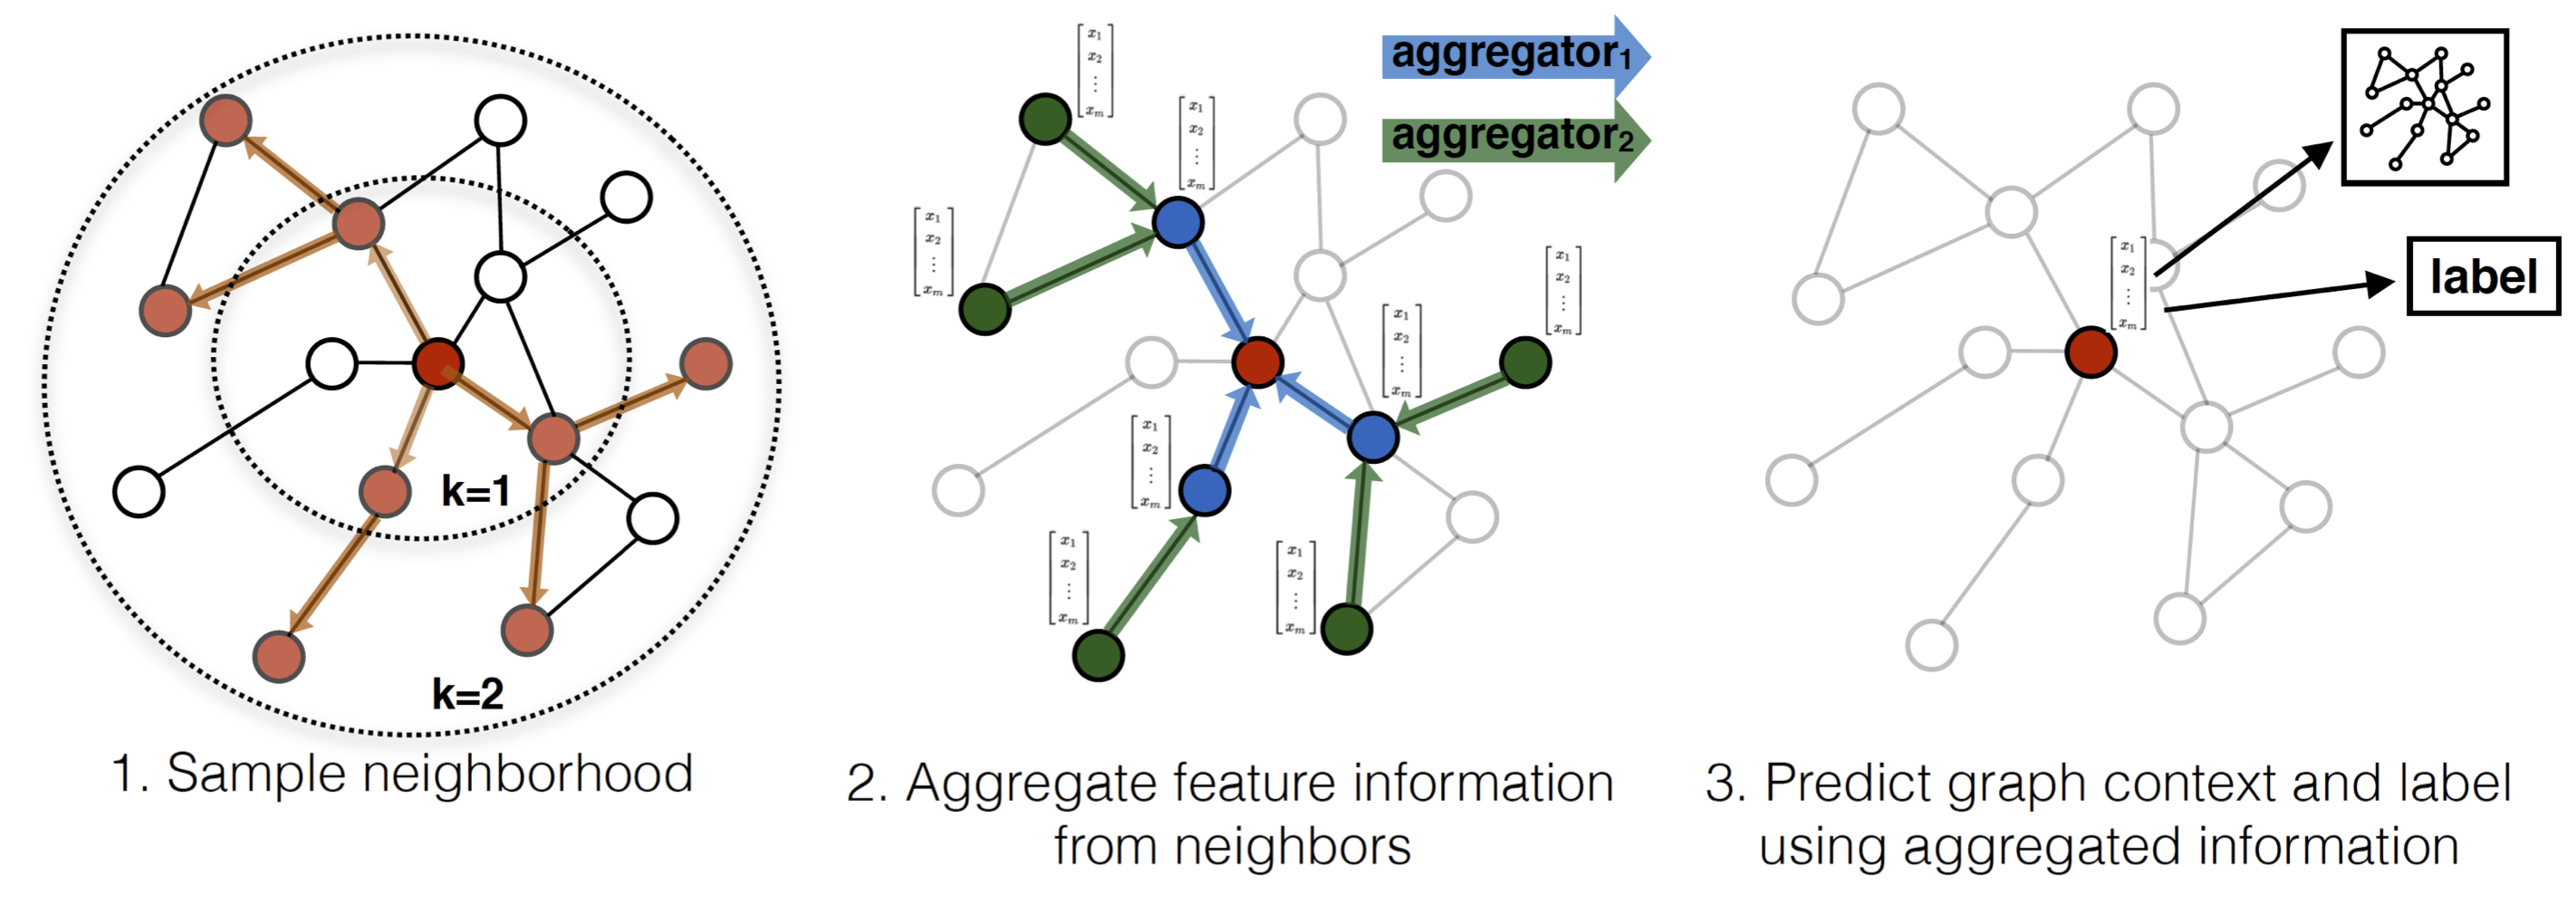

## Predicting Room Adjacencies Using Heterogenous GNN

#### Load data

In [30]:
%%capture
download_gnn_dataset()

In [29]:
with open("data/gnn_train.pkl","rb") as f: train_data = pickle.load(f)
with open("data/gnn_val.pkl","rb") as f: val_data = pickle.load(f)
with open("data/gnn_test.pkl","rb") as f: test_data = pickle.load(f)

type_shapes = dict(map(lambda k: [k, [*train_data[k].x.shape]], train_data.metadata()[0]))

print("Edge type shapes:\n")
print('\n'.join(map(str,type_shapes.items())))

Edge type shapes:

('site', [1460, 11])
('building', [3173, 11])
('level', [13693, 11])
('zone', [85981, 11])
('room', [398437, 11])
('polygon', [398437, 11])


- The data is split into train, validation and test sets, by following a stratified approach, where residential units from the same building cannot be part of the same set.<br>

- The reason is that it is very common for buildings to have similar (or identical) apartments on different floors, which would violate the requirement that train, validation and test sets are actually disjoint.<br>

- Additionally, in order to add negative examples for our training objective, we generated combinations of all rooms within each unit, and labeled them accordingly (depending on whether there exists an actual connection or not). We also added negative examples of connections to rooms of different apartments. 

- The node features were generated as such: 
    - For the geometrical nodes we produced 11-dimensional feature vectors, by using simple geometrical descriptors of the polygons.<br>
    
    - For all non-geometrical nodes we produced a word embedding of the ontology-type name (together with the attached rdfs:labels) using a pre-trained BERT model. Assuming that the terms are given and finite, we reduced the vector embedding size using PCA and kept the 11 first components for simplicity (in practice we would probably skip this step).

#### Define model

In [49]:
class GNN(torch.nn.Module):

    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


class Classifier(torch.nn.Module):

    def __init__(self, hidden_channels, dropout=0.2):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x_room: torch.Tensor, edge_label_index: torch.Tensor):
        z = torch.cat([x_room[edge_label_index[0]], x_room[edge_label_index[1]]], dim=-1)
        z = self.lin1(z).relu()
        z = self.dropout(z)
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):

    def __init__(self, hidden_channels, shapes, metadata):
        super().__init__()
        # we initialise learnable weights for all the nodes to obtain rich feature representations
        for key,val in shapes.items():
            setattr(self, key + "_lin", torch.nn.Linear(val[-1], hidden_channels))
            setattr(self, key + "_emb", torch.nn.Embedding(val[0], hidden_channels))
        self.metadata = metadata
        self.gnn = GNN(hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata=metadata)
        # add a classifer for the link prediction task
        self.classifier = Classifier(hidden_channels=hidden_channels)

    def forward(self, data: HeteroData) -> torch.Tensor:
        x_dict = {}
        for t in self.metadata[0]:
            lin = getattr(self,t+"_lin")
            emb = getattr(self,t+"_emb")
            x_dict[t] = lin(data[t].x) + emb(data[t].node_id)
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["room"],
            data["room", "adjacentzone", "room"].edge_label_index
        )
        return pred


model = Model(64, type_shapes,  train_data.metadata())
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.device_count()>0 else 'cpu' )
print(f"Device: '{device}'")
model = model.to(device)

Device: 'mps'


#### Train model

In [7]:
edge_label_index = train_data["room", "adjacentzone", "room"].edge_label_index
edge_label = train_data["room", "adjacentzone", "room"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data.contiguous(),
    num_neighbors=[20, 10],
    neg_sampling_ratio=0.0,
    edge_label_index=(("room", "adjacentzone", "room"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1, 3):
    total_loss = 0
    total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["room", "adjacentzone", "room"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

#### Evaluate model

Optionally load trained model

In [50]:
model_links = {
    "model_cpu": "1X6XYkjJgDHKf-V6jEkPo1-mjOYaiYJOk",
    "model_cuda": "1wQnOuvmszmvFgXMhZKR_qL6rfzba7fkJ"
}
model_name = "model_cuda" if torch.cuda.is_available() else "model_cpu"
download_file(model_links.get(model_name), f"data/{model_name}.pkl")

In [51]:
with open(f"data/{model_name}.pkl","rb") as f:     
    model = pickle.load(f)
model = model.to(device)

In [53]:
edge_label_index = val_data["room", "adjacentzone", "room"].edge_label_index
edge_label = val_data["room", "adjacentzone", "room"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data.contiguous(),
    num_neighbors=[20, 10],
    neg_sampling_ratio=0.0,
    edge_label_index=(("room", "adjacentzone", "room"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

In [54]:
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["room", "adjacentzone", "room"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {100*auc:.2f}%")

100%|██████████| 703/703 [02:48<00:00,  4.17it/s]


Validation AUC: 91.75%


More info for the AUC score: [ROC_AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

#### Testing

In [33]:
%%capture
download_file("1IcAYIlxTvvh9N4wRmjYfk01mdIFGiIMr", "data/id_mapping.pkl")

In [34]:
with open("data/id_mapping.pkl", "rb") as f: id_mapping = pickle.load(f)

In [35]:
def infer_edges(data, test_unit_id, threshold=0.5):
    s,e,t ="room", "adjacentzone", "room"
    data = copy(data)
    test_unit_rooms = data['room'].node_id[data['room'].unit_id == test_unit_id].cpu().numpy()
    test_unit_rooms_edges = [*combinations(test_unit_rooms,2)]
    test_unit_rooms_edges = torch.Tensor(test_unit_rooms_edges).T.long()
    data[s,e,t].edge_label_index = test_unit_rooms_edges
    data = data.to(device)
    with torch.no_grad():
        new_pred = torch.sigmoid(model(data)).cpu().numpy().round(3)
    del data
    res = test_unit_rooms_edges[:,new_pred >= threshold].T.numpy()
    return res

In [36]:
new_data = copy(test_data)
test_units = new_data["room", "adjacentzone", "room"].unit_id.unique().numpy()

Using the test set from the dataset split, we can see the performance of the trained model on new, unseen examples. <br> The `test_units` array contains the ids for all the test residential units. <br>The `id_mapping` dictionary maps the ids to the uris of the rdf graph.

In [56]:
index = 10
test_unit = test_units[index]
test_unit_uri = id_mapping["zones"][test_unit]
print(f"Test residential unit uri : {test_unit_uri}")

actual_graph = get_subgraph(g, test_unit_uri, 3)

Test residential unit uri : ex:2c463e3d-c646-5d9a-92d1-6bafd37cec9e


In [57]:
plot_floorplan(actual_graph, size=500, attr="rec:coordinates",names=polygon_room_names(actual_graph))

We remove all the edges coming from the rdf graph that are of the `bot:adjacentZone` type to visualise the input the to the model.

In [58]:
test_graph = actual_graph.copy().to_undirected()
for e in test_graph.edges():
    if test_graph.edges[e]['type']=="bot:adjacentZone":
        test_graph.remove_edge(*e) 

plot_graph(test_graph,node_label="rdf:type", edge_label="type", features="rdf:type")

GraphWidget(layout=Layout(height='770px', width='100%'))

- Given a set of nodes we produce all the possible combinations (creating a complete graph) and feed it to the trained model as an input. <br>

- For each pair, the model will output a probability of whether there exists an actual edge (room connection) or not. <br>

- The `threshold` parameter controls how tolerant or strict we want to be with the model's predictions. <br> A value of 1.0 would return only predictions of 100% confidence, while a value 0.0 would return all possible room combinations.

In [59]:
threshold = 0.6

# The final predictions are sensitive to the threshold value, 
# which would need to be defined based on the use case.
# When changing the threshold value, re-run :

test_graph = actual_graph.copy().to_undirected()
for e in test_graph.edges():
    if test_graph.edges[e]['type']=="bot:adjacentZone":
        test_graph.remove_edge(*e) 

infered_edges = infer_edges(new_data, test_unit, threshold=threshold)
infered_edges_uris = {}
for n1,n2 in infered_edges:
    uri1 = id_mapping["rooms"][n1]
    uri2 = id_mapping["rooms"][n2]
    infered_edges_uris[(uri1,uri2)] = {"type":"bot:adjacentZone"}

test_graph.add_edges_from(infered_edges_uris)
nx.set_edge_attributes(test_graph,infered_edges_uris)

In [60]:
plot_graph(test_graph, node_label="rdf:type", edge_label="type", features="rdf:type")

GraphWidget(layout=Layout(height='770px', width='100%'))

We can visualise the actual room connections, by plotting the unit's graph without removing the `bot:adjacentZone`-type edges

In [61]:
plot_graph(actual_graph, node_label="rdf:type", edge_label="type", features="rdf:type")

GraphWidget(layout=Layout(height='770px', width='100%'))

Evaluating a single test example

In [62]:
actual_edges = []
for actual_edge in actual_graph.edges():
    if actual_graph.edges[actual_edge]['type'] == 'bot:adjacentZone':
        actual_edges.append(tuple(sorted(actual_edge)))

pred_edges = []
for pred_edge in test_graph.edges():
    if test_graph.edges[pred_edge]['type'] == 'bot:adjacentZone':
        pred_edges.append(tuple(sorted(pred_edge)))

## TP, FP, FN, TN
all_possible_edges = int((len(actual_graph)*(len(actual_graph)-1))/2)
true_positive = len(set(pred_edges).intersection(set(actual_edges)))
false_positive = len(set(pred_edges).difference(set(actual_edges)))
false_negative = len(set(actual_edges).difference(set(pred_edges)))
true_negative = all_possible_edges - (true_positive+false_positive+false_negative)

# RECALL
true_positive_rate = true_positive / (true_positive + false_negative) 
# TYPE 1 ERROR
false_positive_rate = false_positive / (false_positive + true_negative) 

print(f"Threshold {threshold}:\n")
print(f"\tTPR : {100*true_positive_rate:.2f}%")  # large is good
print(f"\tFPR : {100*false_positive_rate:.2f}%") # small is good

Threshold 0.6:

	TPR : 91.67%
	FPR : 1.47%


#### Resources for ML with Graphs


[Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) is a great library for building GNNs, as well as a great learning resource.<br>

[Machine Learning with Graphs](https://youtube.com/playlist?list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn) is a great series of lectures from Stanford's professor [Jure Leskovec](https://cs.stanford.edu/people/jure/).<br>

Also, you can follow [Geometric Deep Learning](https://geometricdeeplearning.com) for a more foundational understanding of these topics.

## Graph Rag (WIP)

In [65]:
%%capture
download_file("1aX0Y2l387OKwOHZPUNqGcnwqezL4nk5p", "data/rdf_graph_no_geom.ttl")

In [67]:
if 'rdf' not in locals():
    rdf = Graph()
    rdf.parse("data/rdf_graph_no_geom.ttl")
    
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass('Enter your openai api key')

In [68]:
PREFIXES = """
PREFIX bot: <https://w3id.org/bot#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rec: <https://w3id.org/rec#>\n
"""

PROMPT_GET_SPARQL = f'''
Given the following RDF 'Schema' of a Knowledge Graph containing data about buildings, create a SPARQL query for the 'Question' provided.
The ontologies used are Real Estate Core (rec) and Building Ontology Topology (bot).
Your answer should be strictly the SPARQL query without any comments and without adding the prefixes mapping.
VERY IMPORTANT: The graph is big, so make sure that the query is optimized and doesn't crash or time-out. 

Schema:
- rec:Site rec:hasPart rec:Building  (a building site contains one or more buildings)
- rec:Building rec:hasPart rec:Level (a building contains one or more floors)
- rec:Level rec:hasPart rec:Zone (a floor contains one or more apartments)
- rec:Zone rec:hasPart rec:Zone (an apartment contains one or more divisions - per floor)
- rec:Zone rec:hasPart rec:Room (an apartment division contains one or more rooms)
- rec:Room bot:adjacentZone rec:Room (a room is connected to one or more rooms)
The literal values associated with any entity are assigned as 'rdfs:label' properties.

Question:
{{question}}
'''

PROMPT_GET_RESPONSE = f'''
The following question was translated to a SPARQL query that was used against a Knowledge Graph.
The response, serialized as json, is also provided.
Your task is to produce a simple human readable answer to the question from the information provided.
If the response is empty simply answer that you don't know the answer. 

Question:
{{question}}

Response:
{{response}}
'''

PROMPT_CHECK_SPARQL = f'''
You are an AI assistant that was prompted for the following task:

PROMPT:
{PROMPT_GET_SPARQL}

And you provided the following output:

OUTPUT:
{{response}}

Which yielded the following db response (sample):

RESPONSE:
{{sample}}

Your current task is to reconsider you response and modify if neccessary.
The graph is big, so make sure that the query is optimized.
As before you are only allowed to provided valid SPARQL queries as outputs (no comments etc.).
'''


def post_process_sparql_text(
    text: str
) -> str:
        
    sparql = re.search(r"```(?:sparql)?(.*?)```", text, re.DOTALL)
    query = sparql.group(1).strip() if sparql else text
    return query


def ask_chatgpt(
    inputs: dict,
    prompt: str,
    openai_model: str = "gpt-4o",
    post_process: callable = lambda x: x
) -> str:

    client = OpenAI()
    response = client.chat.completions.create(
        model=openai_model,
        messages=[{"role": "user", "content": prompt.format_map(inputs)}],
        stream=False,
    )
    answer = response.choices[0].message.content
    return post_process(answer)


def ask_kg(
    question: str,
    rdf: rdflib.Graph,
    iterate: bool = True,
    verbose: bool = False
) -> str:
    
    sparql = ask_chatgpt(
        inputs=dict(question=question), 
        prompt=PROMPT_GET_SPARQL, 
        post_process=post_process_sparql_text
    )
    if verbose:
        print(f"Generated SPARQL:\n{sparql}\n\n")
    try:
        if iterate:
            response = rdf.query(PREFIXES + sparql)
            snippet = response.serialize(format="json").decode()[:300]     
            sparql_checked = ask_chatgpt(
                inputs=dict(question=question, response=sparql, sample=snippet), 
                prompt=PROMPT_CHECK_SPARQL, 
                post_process=post_process_sparql_text
            )
            if verbose:
                print(f"Reviewed SPARQL:\n{sparql_checked}\n\n")
            response = rdf.query(PREFIXES + sparql_checked)
        else:
            response = rdf.query(PREFIXES + sparql)
        serialized = response.serialize(format="json").decode()[:10000]
        if verbose:
            print(f"SPARQL Response:\n{serialized}\n\n")
        answer = ask_chatgpt(
            inputs=dict(question=question, response=serialized), 
            prompt=PROMPT_GET_RESPONSE,
            openai_model="gpt-4o-mini"
        )
        return answer
    except Exception as e:
        print(e)
        return None

In [ ]:
#################
# ! Attention ! # This is WIP and the SPARQL query generated by the LLM might be sub-optimal and make the process time-out or crash
#################

# question = "What is the sum of all the buildings that have more than 6 floors?"
question = "How many 'KITCHEN' rooms are on each building on average?"
question = "What is the number of 'KITCHEN' rooms in the dataset?"
question = "What is the number of buildings in the dataset?"



answer = ask_kg(question, rdf, iterate=True, verbose=True)
print(answer)